In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')

In [2]:
import scanpy as sc
import anndata as ad

In [3]:
from data import TransformedMeanDataset
from tqdm import tqdm
ds_train = TransformedMeanDataset('train')
ds_validation = TransformedMeanDataset('validation')
ds_test = TransformedMeanDataset('test')
from jupy import *

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [4]:
import torch
list_of_t = []
list_of_patient_index = []
for i, t in enumerate(tqdm(ds_train)):
    list_of_t.append(t)
    ii = torch.tensor([i] * len(t))
    list_of_patient_index.append(ii)
t_train = torch.cat(list_of_t, dim=0)
patient_indexes = torch.cat(list_of_patient_index)
print(t_train.shape)

100%|██████████| 215/215 [00:02<00:00, 95.07it/s] 

torch.Size([442113, 39])


In [8]:
from data import RawMeanDataset, RawMean12, NatureBImproved, NatureBOriginal, TransformedMeanDataset

class A:
    def __init__(self, model, model_id):
        self.model = model
        self.model_id = model_id
        self.instance = model + '_' + model_id
        if self.model_id == 'raw_mean_dataset':
            self.dataset = RawMeanDataset
        elif self.model_id == 'raw_mean12':
            self.dataset = RawMean12
        elif self.model_id == 'nature_b_improved':
            self.dataset = NatureBImproved
        elif self.model_id == 'nature_b_original':
            self.dataset = NatureBOriginal
        elif self.model_id.startswith('transformed_mean_dataset'):
            self.dataset = TransformedMeanDataset
        else:
            raise ValueError(self.instance)
        self.ds_train = self.dataset('train')
        self.ds_validation = self.dataset('validation')

instances = [A('vae', 'raw_mean12'), A('vae', 'transformed_mean_dataset'), A('vae', 'transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False')]
import h5py
from data import file_path

In [20]:
from models.train_vae import Vae
import ignite.distributed as idist
from h5_logger import H5Logger
import torch
from tqdm import tqdm

for instance in instances: 
    model = Vae(in_channels=39, hidden_layer_dimensions=5, out_channels=39)
    model = model.to(idist.device())
    model.load_state_dict(torch.load(the_path(instance, 'model.torch')))
    for split in ['train', 'validation']:
        path = the_path(instance, f'embedding_{split}.hdf5')
        if os.path.isfile(path):
            os.remove(path)
        if not os.path.isfile(path):
            EPOCH = 50
            print(f'embedding not found, creating it for EPOCH = {EPOCH}, path =', path)
            embedding_training_logger = H5Logger(path)
            embedding_training_logger.clear()
            if split == 'train':
                ds = instance.ds_train
            elif split == 'validation':
                ds = instance.ds_validation
            else:
                raise ValueError()

            # only_first_5_samples = False
            with torch.no_grad():
                list_of_reconstructed = []
                list_of_mu = []
                list_of_log_var = []
                iterator = tqdm(ds, desc='embedding', position=0, leave=True)
                for i, data in enumerate(iterator):
                    data.to(idist.device())
                    data = torch.unsqueeze(data, 0)
                    # data = [torch.unsqueeze(x, 0) for x in data]
                    recon_batch, mu, log_var = model.forward_step(data, model)
                    ome_filename = ds.filenames[i]

                    def u(x):
                        if len(x.shape) == 3 and x.shape[0] == 1:
                            x = x.reshape(-1, x.shape[2])
                        return x

                    f = lambda x: x.cpu().detach().numpy()
                    # reconstructed = ome_dataset.scale_back(reconstructed.cpu().detach(), i)
                    a = f(u(recon_batch))
                    b = f(u(mu))
                    c = f(u(log_var))
                    data = {f'{ome_filename}/reconstructed': a,
                            f'{ome_filename}/mu': b,
                            f'{ome_filename}/log_var': c}
                    embedding_training_logger.log(EPOCH, data)

embedding:   0%|          | 0/215 [00:00<?, ?it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_raw_mean12/embedding_train.hdf5


embedding:  11%|█         | 13/119 [00:00<00:00, 125.30it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_raw_mean12/embedding_validation.hdf5


embedding:   4%|▎         | 8/215 [00:00<00:02, 76.83it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset/embedding_train.hdf5


embedding:   9%|▉         | 11/119 [00:00<00:01, 105.07it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset/embedding_validation.hdf5


embedding:   4%|▍         | 9/215 [00:00<00:02, 89.93it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False/embedding_train.hdf5


embedding:   8%|▊         | 9/119 [00:00<00:01, 83.70it/s]

embedding not found, creating it for EPOCH = 50, path = /data/l989o/deployed/a/data/spatial_uzh_processed/a/vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False/embedding_validation.hdf5


embedding: 100%|██████████| 119/119 [00:01<00:00, 99.11it/s] 


In [22]:
def the_path(instance, f):
    root = file_path(instance.instance)
    assert os.path.isdir(root), root
    return os.path.join(root, f)

In [23]:
from scipy.stats import spearmanr
import numpy as np

all_k = set()
for instance in instances:
    print(instance.instance, 'train')
    f = the_path(instance, 'embedding_train.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        all_k.add(k)
        assert len(all_k) <= 1, all_k
        if bbb:
            print(f'EPOCH {k}', flush=True)
            
        o_train = instance.ds_train.filenames        
        spearman_train_list = []
        for i, o in enumerate(tqdm(o_train, desc='spearamn train')):
            original = instance.ds_train[i].numpy()
            reconstructed = v[o]['reconstructed'][...]
            assert original.shape == reconstructed.shape
            correlations = []
            for c in range(39):
                x = original[:, c]
                y = reconstructed[:, c]
                r, p_value = spearmanr(x, y)
                correlations.append(r)
            corr = np.array(correlations).reshape((1, -1))
            spearman_train_list.append(corr)
        spearman_train = np.concatenate(spearman_train_list, axis=0)
        instance.spearman_train = spearman_train
        
    print(instance.instance, 'validation')
    f = the_path(instance, 'embedding_validation.hdf5')
    with h5py.File(f, 'r') as f5:
        assert len(f5.keys()) == 1
        k, v = f5.items().__iter__().__next__()
        if len(all_k) == 0:
            bbb = True
        print('k = ', k)
        print('all_k =', all_k, flush=True)
        all_k.add(k)
        assert len(all_k) <= 1, all_k
        if bbb:
            print(f'EPOCH {k}', flush=True)
            
        o_validation = instance.ds_validation.filenames        
        spearman_validation_list = []
        for i, o in enumerate(tqdm(o_validation, desc='spearamn validation')):
            original = instance.ds_validation[i].numpy()
            reconstructed = v[o]['reconstructed'][...]
            assert original.shape == reconstructed.shape
            correlations = []
            for c in range(39):
                x = original[:, c]
                y = reconstructed[:, c]
                r, p_value = spearmanr(x, y)
                correlations.append(r)
            corr = np.array(correlations).reshape((1, -1))
            spearman_validation_list.append(corr)
        spearman_validation = np.concatenate(spearman_validation_list, axis=0)
        instance.spearman_validation = spearman_validation
    print()

vae_raw_mean12 train
EPOCH epoch50


spearamn train: 100%|██████████| 215/215 [00:08<00:00, 26.59it/s]


vae_raw_mean12 validation
k =  epoch50
all_k = {'epoch50'}
EPOCH epoch50


spearamn validation: 100%|██████████| 119/119 [00:04<00:00, 27.48it/s]


vae_transformed_mean_dataset train
EPOCH epoch50



spearamn train: 100%|██████████| 215/215 [00:08<00:00, 25.41it/s]

vae_transformed_mean_dataset validation
k =  epoch50
all_k = {'epoch50'}
EPOCH epoch50



spearamn validation: 100%|██████████| 119/119 [00:04<00:00, 27.55it/s]


vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False train
EPOCH epoch50



spearamn train: 100%|██████████| 215/215 [00:08<00:00, 26.20it/s]

vae_transformed_mean_dataset_LR_VB_S_0.0014685885989200848__3.8608662714605464e-08__False validation
k =  epoch50
all_k = {'epoch50'}
EPOCH epoch50



spearamn validation: 100%|██████████| 119/119 [00:04<00:00, 27.50it/s]

In [24]:
raw_train = RawMeanDataset('train')
counts = [(len(a), i) for i, a in enumerate(raw_train)]
counts = sorted(counts, key=lambda x: x[0])
train_sort = np.array([c[1] for c in counts])

raw_val = RawMeanDataset('validation')
counts = [(len(a), i) for i, a in enumerate(raw_val)]
counts = sorted(counts, key=lambda x: x[0])
val_sort = np.array([c[1] for c in counts])

(119, 39)


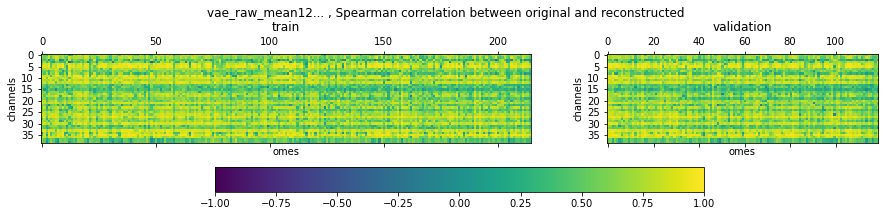

(119, 39)


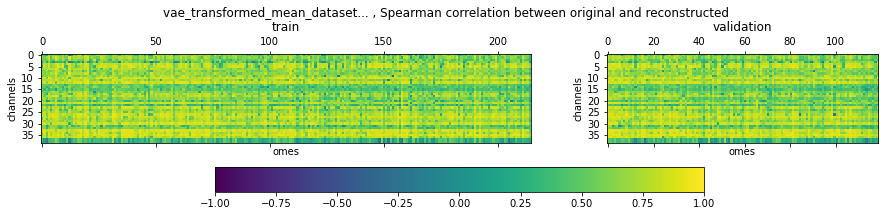

(119, 39)


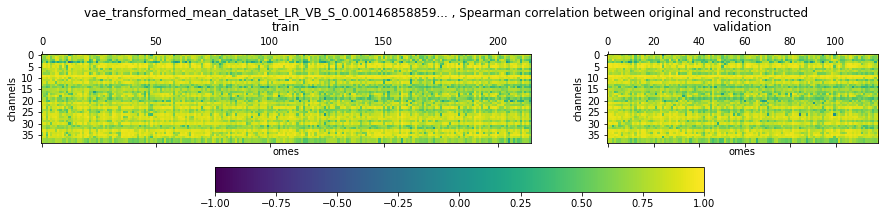

In [28]:
import matplotlib.pyplot as plt
import matplotlib

for instance in instances:
    print(instance.spearman_validation.shape)
    a = len(instance.spearman_train)
    b = len(instance.spearman_validation)
    
    fig = plt.figure(figsize=(15, 3)) # constrained_layout=True, 
#     fig.suptitle(instance.instance)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=(a, b))
    ax0_0 = fig.add_subplot(gs[0, 0])
#     plt.subplot(1, 2, 1)
    plt.matshow(instance.spearman_train[train_sort, :].transpose(), interpolation='nearest', fignum=False)
    plt.clim(-1, 1)
    plt.title(f'train')
    plt.xlabel('omes')
    plt.ylabel('channels')

#     plt.subplot(1, 2, 2)
    ax0_1 = fig.add_subplot(gs[0, 1])
    pcm = plt.matshow(instance.spearman_validation[val_sort, :].transpose(), interpolation='nearest', fignum=False)
    plt.clim(-1, 1)
    plt.title(f'validation')
    plt.xlabel('omes')
    plt.ylabel('channels')
    
    fig.colorbar(pcm, ax=[ax0_0, ax0_1], location='bottom')
        
    plt.suptitle(f'{instance.instance[:50]}... , Spearman correlation between original and reconstructed')
#     plt.tight_layout()
#     gs.tight_layout(fig)
#     gs.update(top=0.95)
#     x = 0.05
#     plt.subplots_adjust(left=x, bottom=x, right=1 - x, top=1 - x, wspace=None, hspace=0.2)
    plt.show()

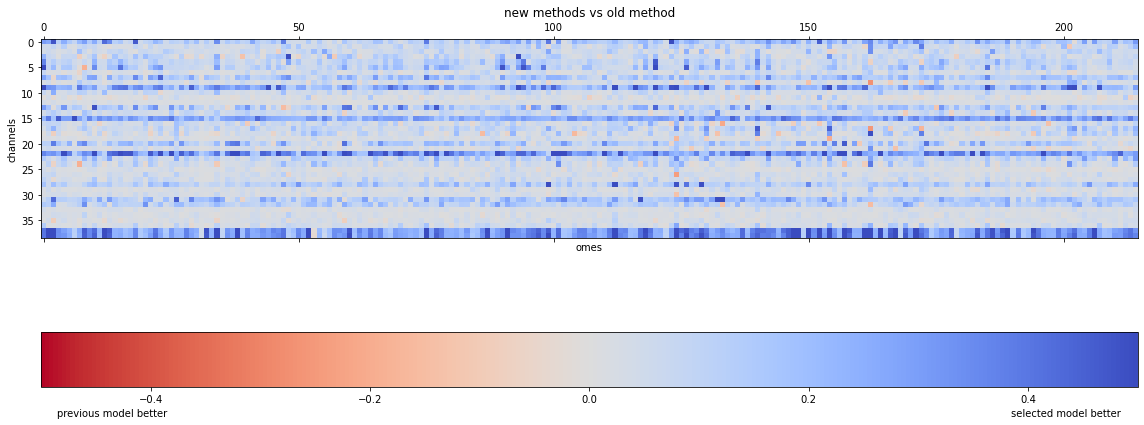

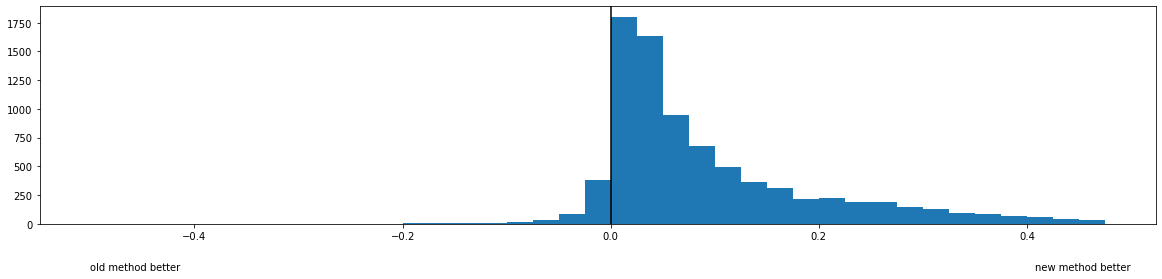

In [30]:
m = instances[2].spearman_train[train_sort, :] - instances[1].spearman_train[train_sort, :]
plt.figure(figsize=(16, 9))
plt.matshow(m.transpose(), fignum=False, cmap='coolwarm_r')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('previous model better' + ' ' * 270 + 'selected model better')
plt.xlabel('omes')
plt.ylabel('channels')
plt.title('new methods vs old method')
plt.clim(-0.5, 0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 4))
plt.hist(m.flatten(), bins=np.arange(-0.5, 0.5, 0.025))
# plt.yscale('log')
plt.axvline(x=0, c='k')
plt.text(-0.5, -400, 'old method better', horizontalalignment='left')
plt.text(0.5, -400, 'new method better', horizontalalignment='right')
plt.show()

100%|██████████| 39/39 [00:01<00:00, 35.01it/s]


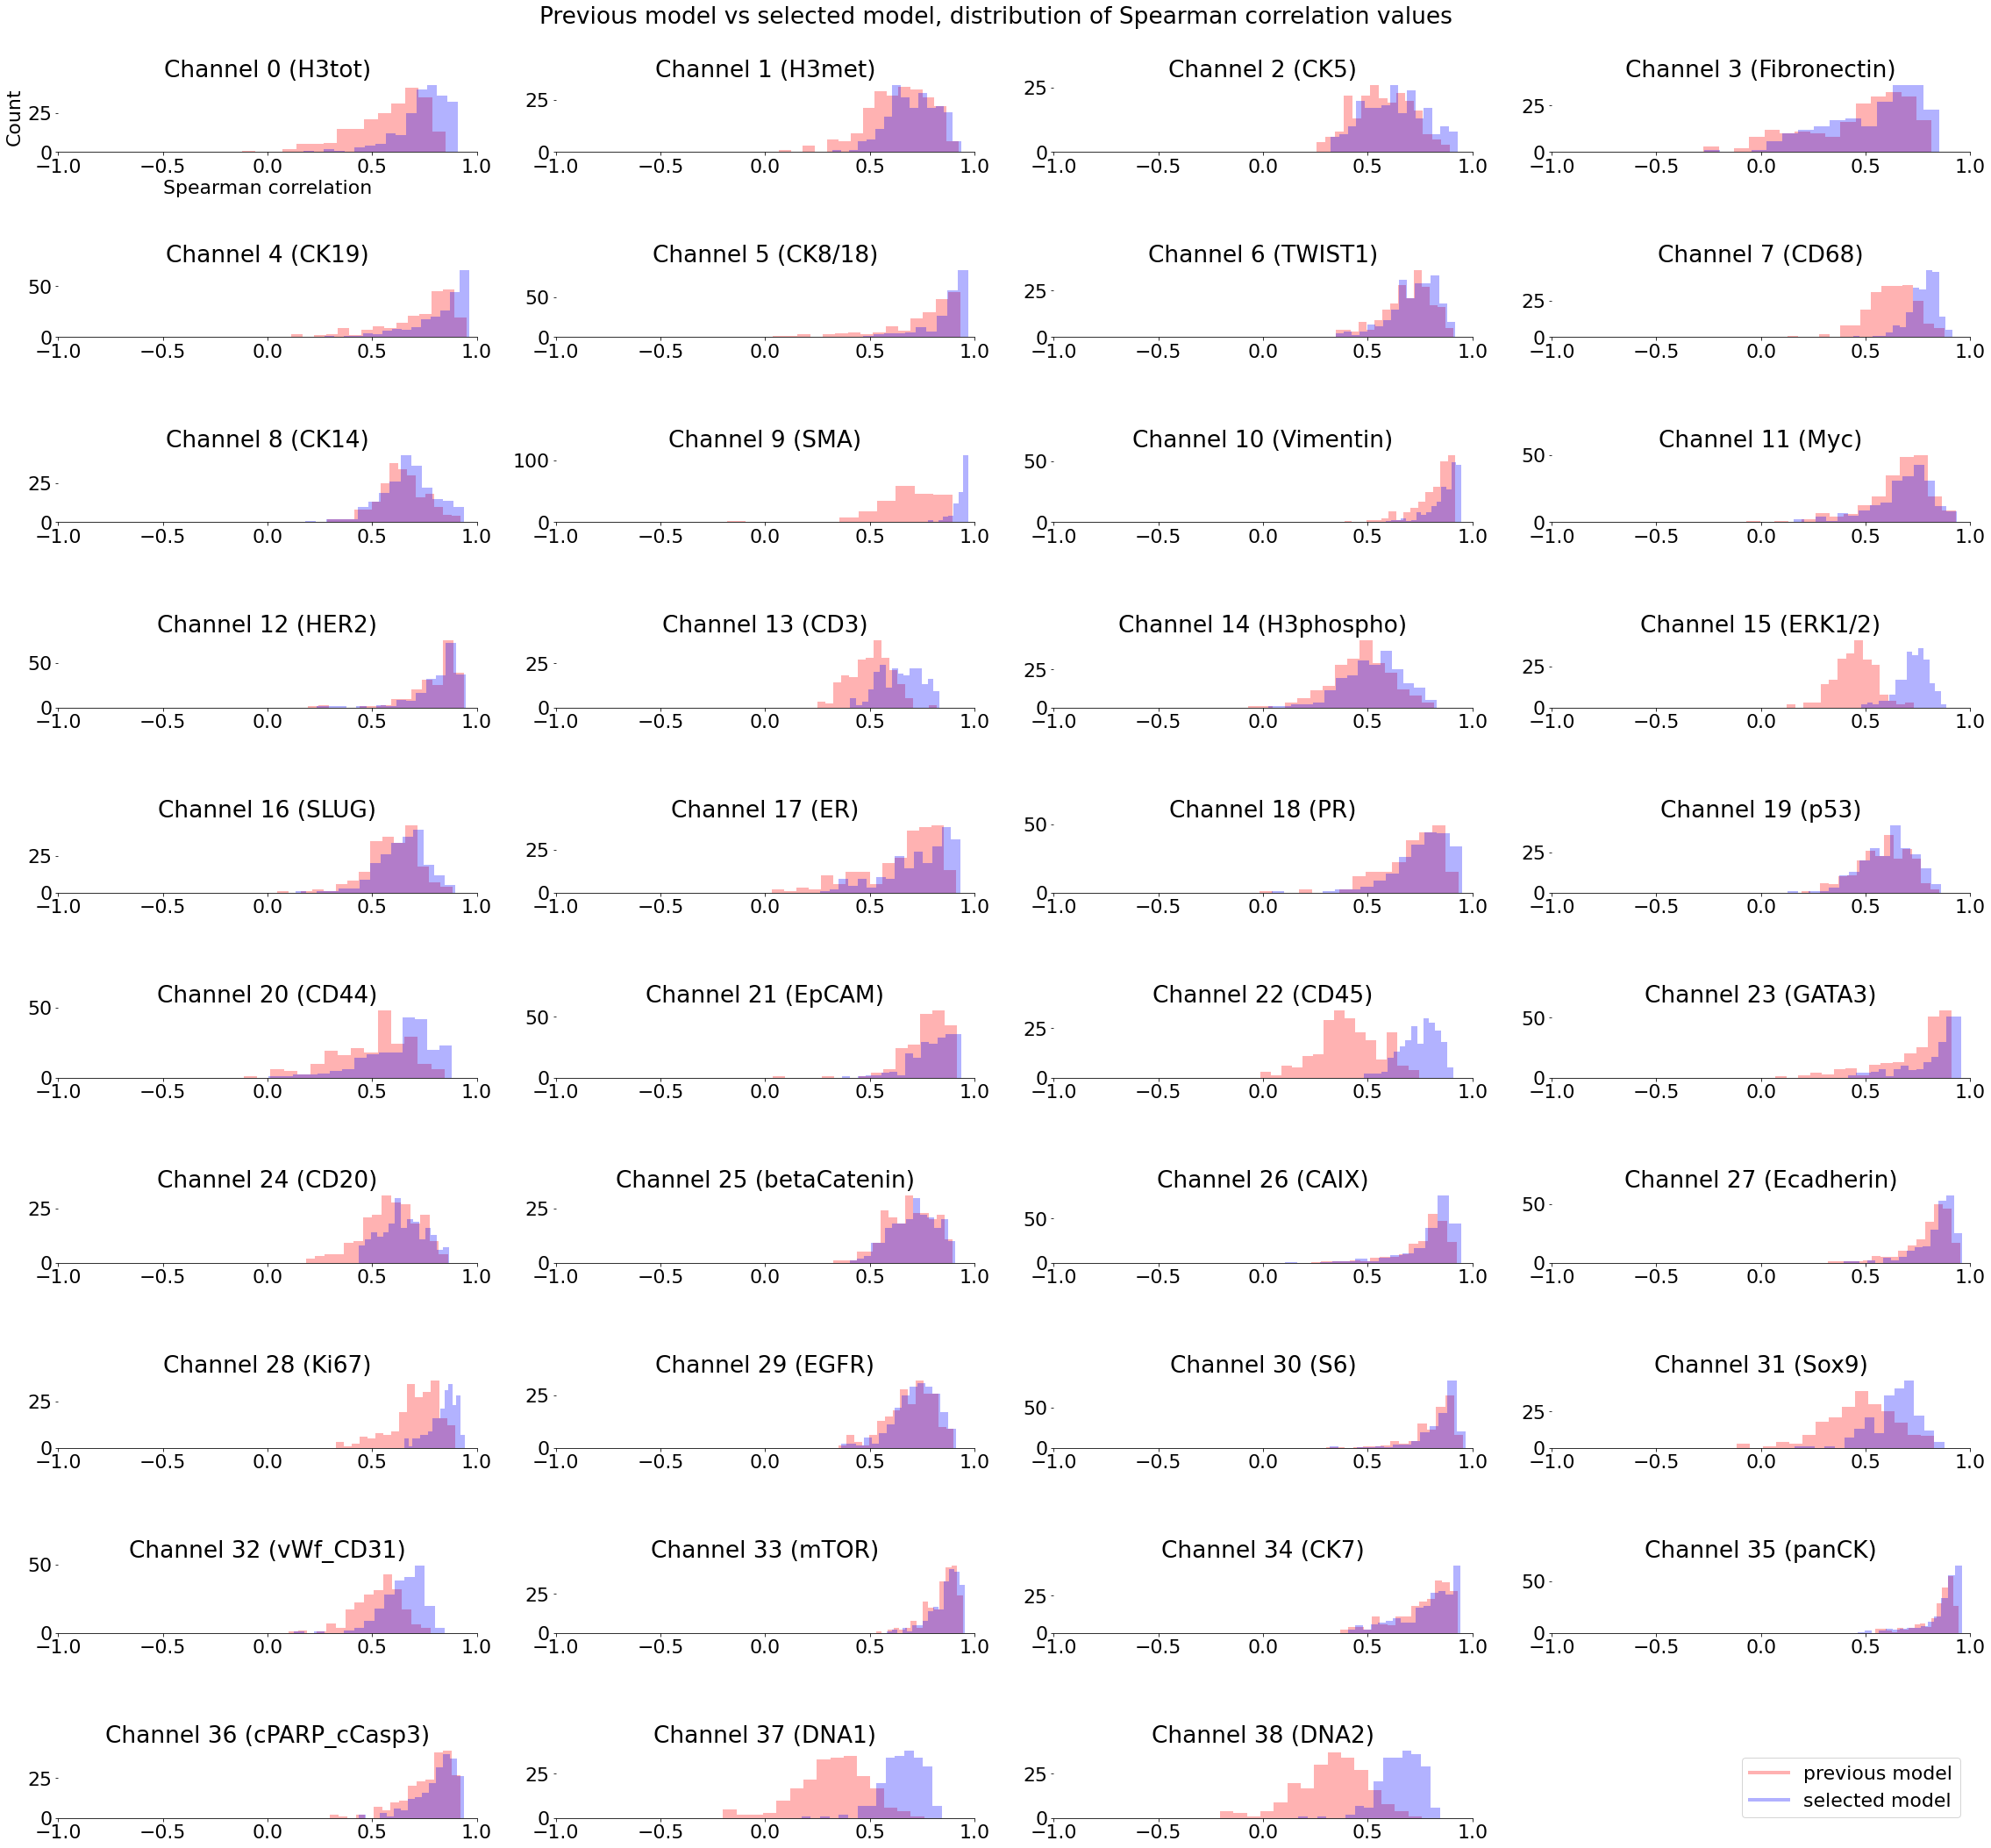

In [35]:
channel_names = ['H3tot', 'H3met', 'CK5', 'Fibronectin', 'CK19', 'CK8/18', 'TWIST1', 'CD68', 'CK14', 'SMA',
                 'Vimentin', 'Myc', 'HER2', 'CD3', 'H3phospho', 'ERK1/2', 'SLUG', 'ER', 'PR', 'p53', 'CD44',
                 'EpCAM', 'CD45', 'GATA3', 'CD20', 'betaCatenin', 'CAIX', 'Ecadherin', 'Ki67', 'EGFR', 'S6',
                 'Sox9', 'vWf_CD31', 'mTOR', 'CK7', 'panCK', 'cPARP_cCasp3', 'DNA1', 'DNA2']

n_bins = 15
fig = plt.figure(figsize=(32, 30))
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
k = 1
for i in tqdm(range(39)):
    ax = plt.subplot(10, 4, k)
    k += 1
    plt.hist(instances[1].spearman_train[:, i].flatten(), bins=n_bins, color=(1., 0., 0., 0.3))
    plt.hist(instances[2].spearman_train[:, i].flatten(), bins=n_bins, color=(0., 0., 1., 0.3))
    ax.title.set_text(f'\nChannel {i} ({channel_names[i]})')
    ax.set_xlim([-1, 1])
    if k == 2:
        ax.set_xlabel('Spearman correlation')
        ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     ax.grid(axis='y')

plt.subplot(10, 4, 40)
plt.axis('off')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=(1., 0., 0., 0.3), lw=4),
                Line2D([0], [0], color=(0., 0., 1., 0.3), lw=4)]
plt.legend(custom_lines, ['previous model', 'selected model'])
# x = 0.05
# plt.subplots_adjust(left=x, bottom=x, right=1 - x, top=1 - x, wspace=None, hspace=0.3)
plt.suptitle(f'Previous model vs selected model, distribution of Spearman correlation values')
plt.tight_layout()
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# plt.close(fig)

In [61]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import plotly.figure_factory as ff

plt.style.use('default')

hist_data = []
group_labels = []
for instance in instances:
    v = instance.spearman_validation.flatten()
    hist_data.append(v)
    group_labels.append(instance.instance if len(instance.instance) < 30 else instance.instance[:30] + '...')
    
import pandas as pd
# let's order the boxplots by increasing mean
means = [np.mean(h) for h in hist_data]
s = np.array([x[1] for x in sorted(zip(means, range(len(means))), key=lambda x: -x[0])])
group_labels = [group_labels[i] for i in s]
hist_data = [hist_data[i] for i in s]
df = pd.DataFrame(dict(zip(group_labels, hist_data)))

In [62]:
new_columns = df.columns.to_series().apply(lambda x: x if len(x) < 30 else x[:30] + '...')
df.columns = new_columns

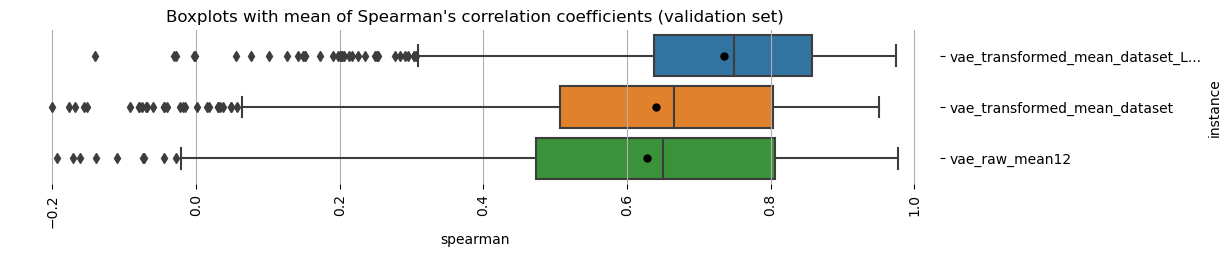

In [63]:
df = df.melt().rename(columns={'variable': 'instance', 'value': 'spearman'})
import seaborn as sns
plt.figure(figsize=(12, 2))
ax = sns.boxplot(x='spearman', y='instance', data=df, orient='h', showmeans=True,
                 meanprops={
                     'marker': 'o',
                     'markerfacecolor': 'black',
                     'markeredgecolor': 'black',
                     'markersize': '5'
                 })
plt.xticks(rotation='vertical')
ax.xaxis.grid()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Boxplots with mean of Spearman\'s correlation coefficients (validation set)')
plt.show()

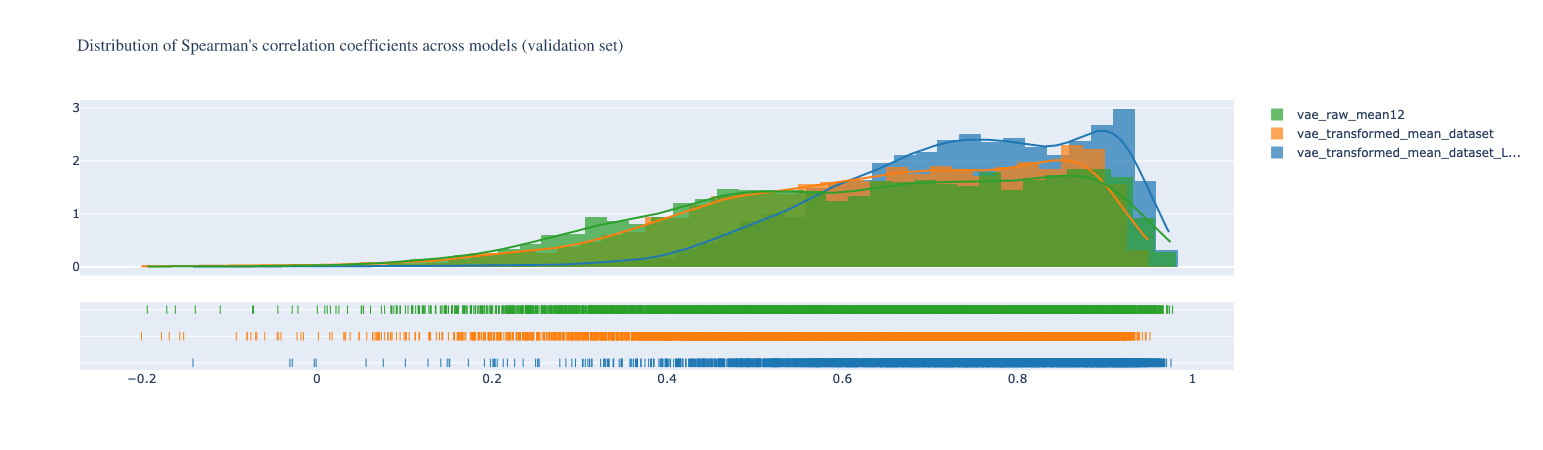

In [64]:
fig = ff.create_distplot(hist_data, group_labels, bin_size=[.025] * len(hist_data), show_rug=True)
# import plotly.express as px
# fig = px.histogram(df, x='spearman', color='instance', marginal='box')
layout = go.Layout(
    title='$\\text{Distribution of Spearman\'s correlation coefficients across models (validation set)}$',
    xaxis_title='$R^2$',
    yaxis_title='$\\text{Density estimation}$')
fig.update_layout(layout)
iplot(fig)

# TODO compare the embeddings!